This notebook loads csv files generated from two simulations of a protein.
Each csv contains time-averaged properties such as Rg (radius of gyration) and RMSF (root mean square fluctuations) for tens of proteins. Each line of the csv represents on protein.

We would like to predict which proteins will fold (e.g. have an RgEnd below a cutoff value of say 18), based on properties reported in this csv file. 
Note that the RgEnd is an output, not a feature used for the prediction. 

Ultimately, I load the data, create a new property called 'isFolded' and proceed to separate the data into inputs (X) and outputs (Y), of which the latter corresponds to the isFolded property value (True/False). X is informed from a feature set defined below. 

I used a decision tree as one of many machine learning approaches that can be tested. 

For the time being, the traj*_scored.csv files will be stored in the repo along with the code


To Generate the initial csv files (for PKH)

<code>
/home/pkekeneshuskey/data/molecular_dynamics/ph_binsun/foldingML
1. process
python3 processSimulations.py -generate -nstruct 99 -case traj3
python3 processSimulations.py -generate -nstruct 99 -case traj7    
2. postprocess 
python3 processSimulations.py -postprocess -nstruct 99 -case traj3
python3 processSimulations.py -postprocess -nstruct 99 -case traj7    
</code>


Note:
- processsimulations includes ScoreFasta for adding information about the system charge
- we also used protonation.ipynb to compute the average protonation and ultimately the charge based on data from Bin Sun. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

#### Loading data sets

In [3]:
dfa = pd.read_csv( "traj3_scored.csv" )
len(dfa.index)

dfb = pd.read_csv( "traj7_scored.csv" )
len(dfb.index)



99

### Apply threshold criterion 

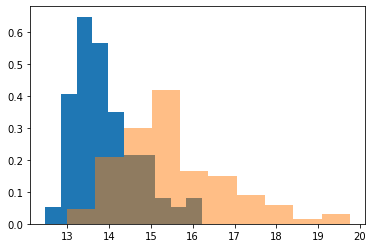

In [50]:
plt.hist(dfa['RgEnd'],density=True,label="pH3")
plt.hist(dfb['RgEnd'],density=True,label="pH7",alpha = 0.5)

cutoff = 14.5

In [51]:
df = pd.concat([dfa,dfb])
df['isFolded']=np.where(df['RgEnd']<cutoff,True,False)

true = np.where(df['isFolded']==True)[0]
print("Folded ",len(true))
false = np.where(df['isFolded']==False)[0]
print("unfolded ",len(false))


Folded  99
unfolded  99


### Create inputs/outputs for ML
We wish to use scalar data, so we are just going to select a subset of features here

In [52]:
print("list of potential columns")
for col in df.columns:
    print(col)

list of potential columns
Unnamed: 0
Unnamed: 0.1
copy
fasta
binEdges
RgHist
RgStart
RgEnd
RMSF
negativeFasta
positiveFasta
negativepH
positivepH
isFolded


In [63]:
feature_cols = ["RgHist","RgStart","RMSF",
                "negativeFasta","positiveFasta","negativepH","positivepH"]
#feature_cols = ["RgStart","RgEnd"]
X = df[feature_cols]
y = df.isFolded

### Learning
borrowed from https://www.datacamp.com/tutorial/decision-tree-classification-python

In [64]:
import sklearn 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [65]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, random_state=1) 

In [66]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [67]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7666666666666667


### Display

In [68]:
!pip3 install six
!pip3 install pydotplus

In [69]:
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
from six import StringIO  
from IPython.display import Image  
import pydotplus

In [70]:
def renderTree(clf):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names = feature_cols,class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return graph 
    

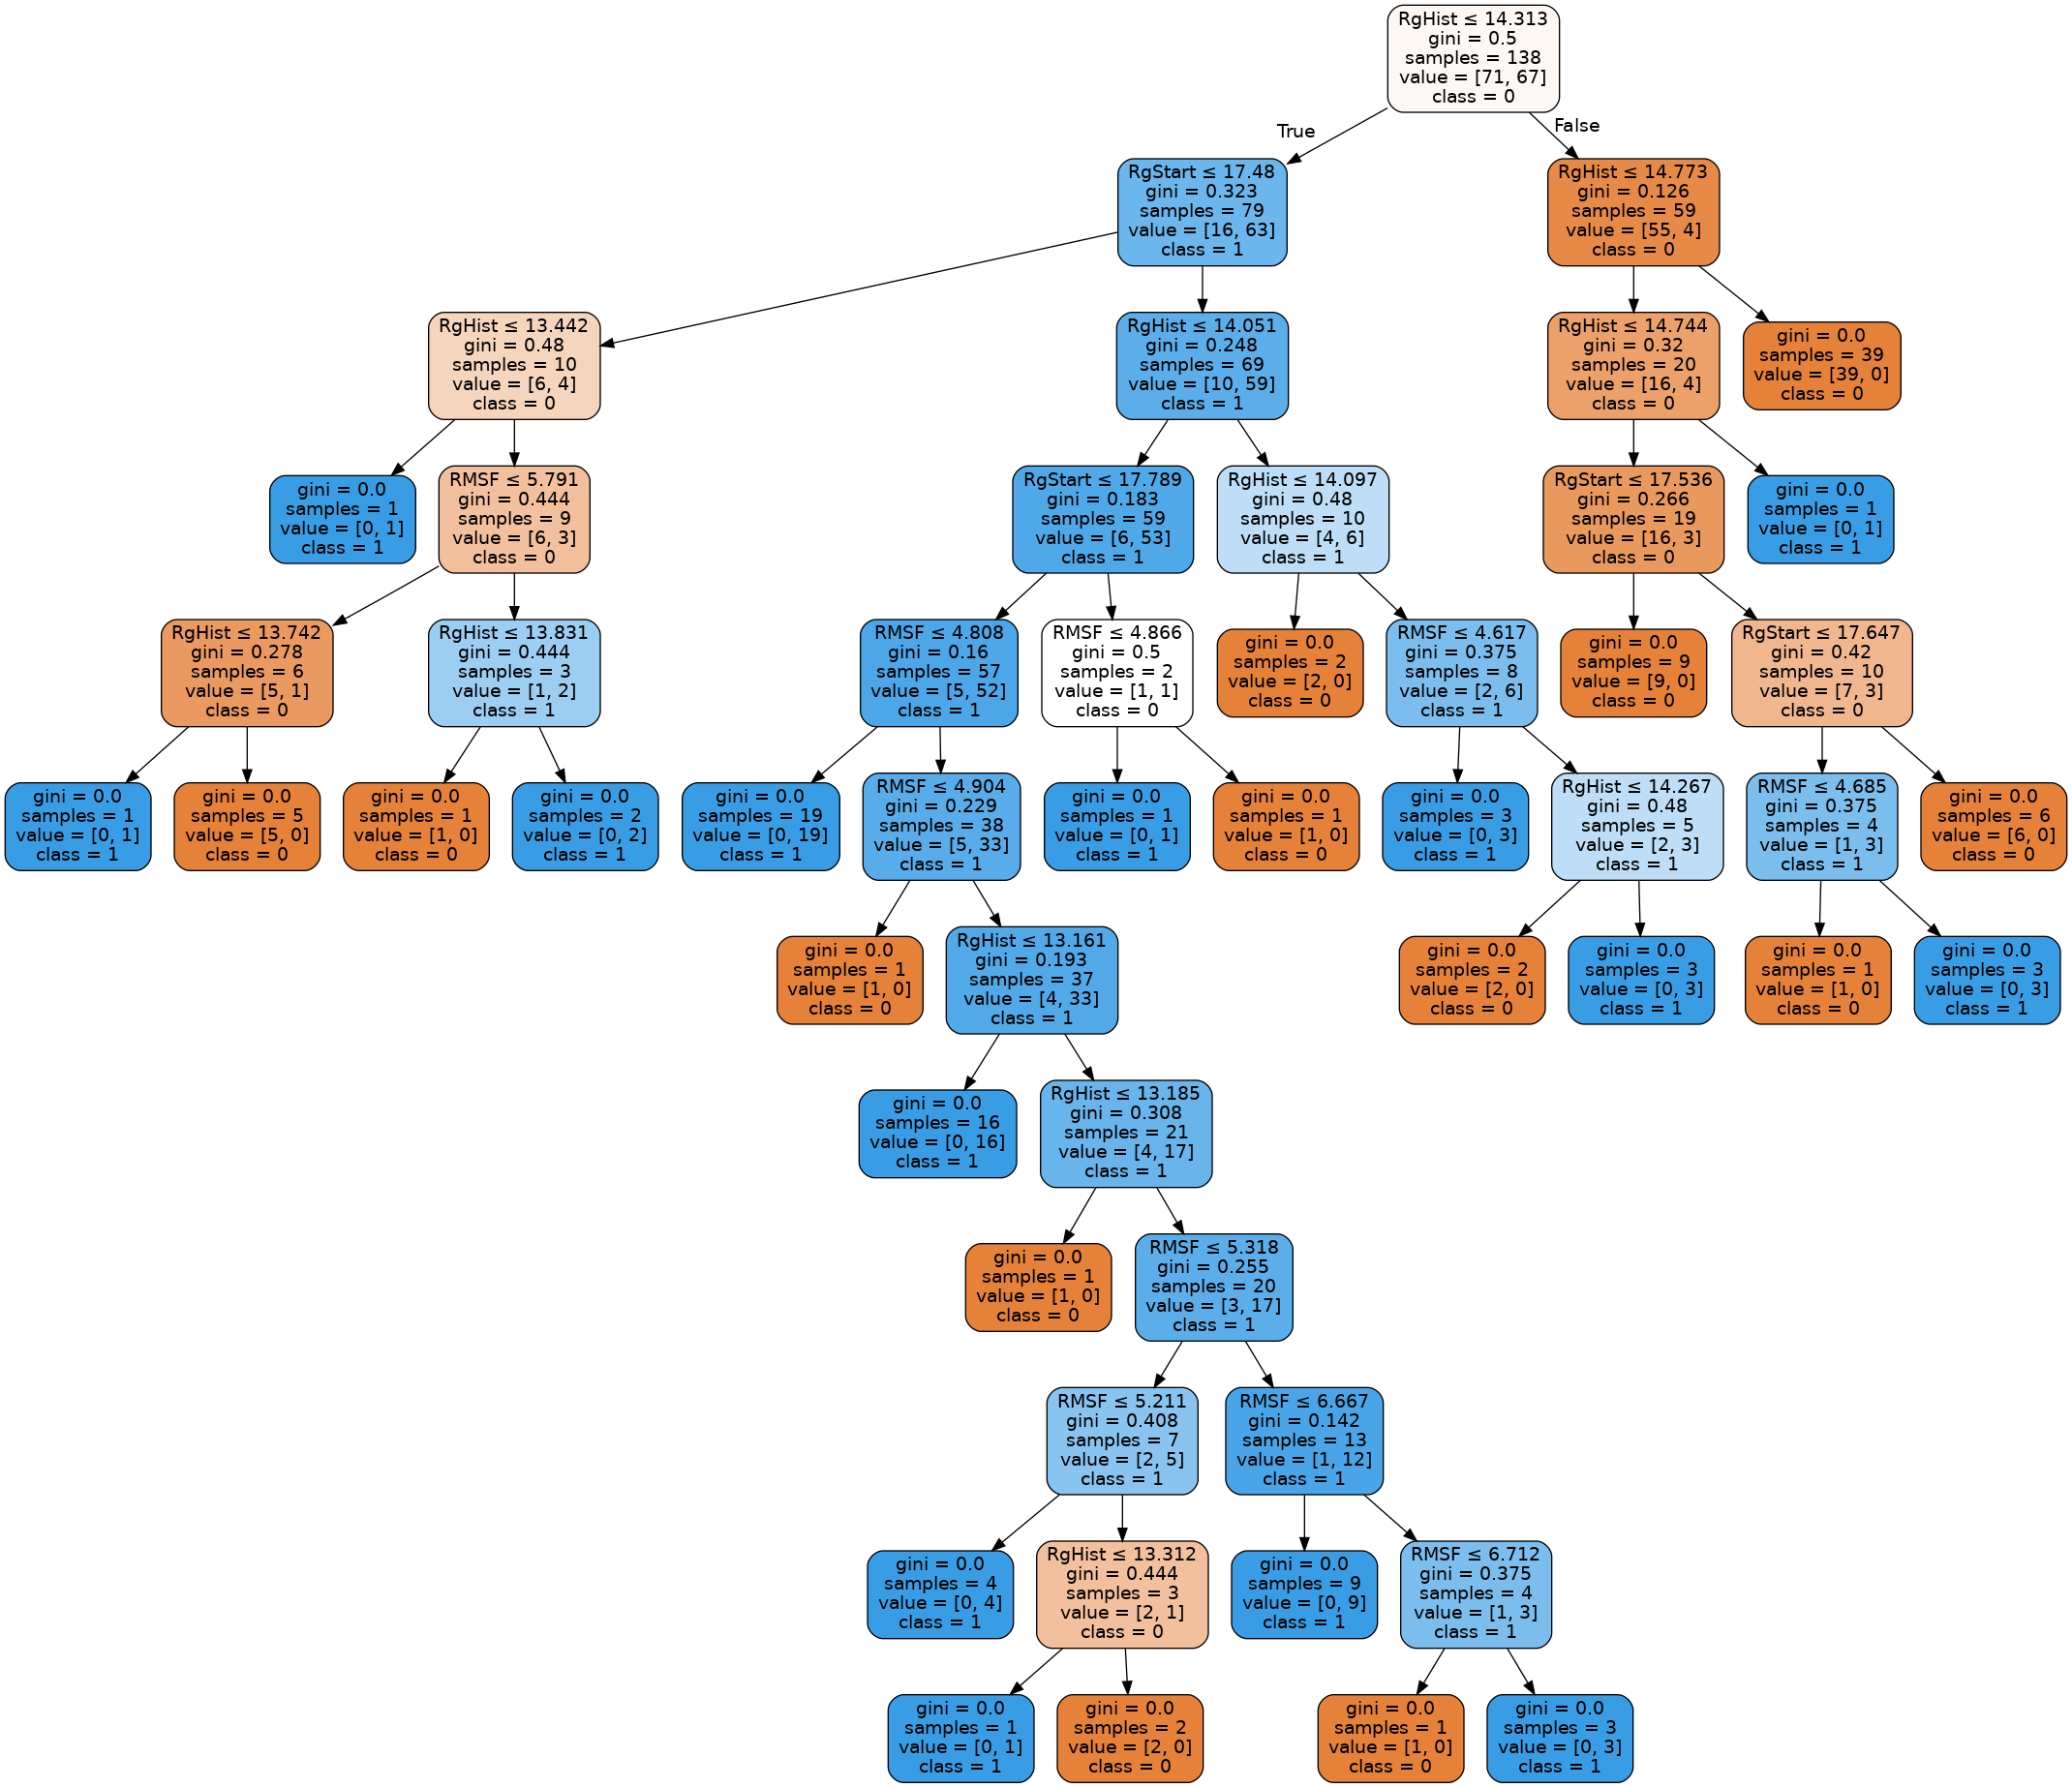

In [71]:
graph = renderTree(clf)
Image(graph.create_png())

## Another project

Preliminary data for grant 

In [18]:
import numpy as np
def randomDraws(df,index,features=["size"],stdDev=3.,draws=1):
  # std dev. s.b. array
  i=index
  sdf = df.iloc[i:(i+1)]
  df_new = pd.DataFrame(np.repeat(sdf.values, draws, axis=0))
  #df_new[feature] = vals
  df_new.columns = df.columns

  for j,feature in enumerate(features):
    refVal = df[feature].values[i]
    vals = refVal + np.random.randn(draws)*stdDev[j] 
    df_new[feature].loc[:] = vals
  #print(df_new)
  return df_new

### Data
- taken from https://docs.google.com/spreadsheets/d/1CGAGCbS_rjDzrF0Ip6tyMQjNmMqCTbk_49azAT8DjNQ/edit#gid=0
<code>
		s	f1	f2	p
ctl		2500	400	-0.75	1
HCM-1		4000	500	-0.5	0.75
HCM-2		6500	550	-0.4	0.6
</code>    


In [35]:
import pandas as pd

data = {
  'cond': ['ctl','hcm1','hcm2'],
  'size': [2500,4000,6500],
  'f1':   [400,500,550],
  'f2':   [-0.75,-0.5,-0.4],
  'p':    [1.,0.75,0.6],
  'isCtl': [True,False,False]
}

df = pd.DataFrame.from_dict(data)

### Pad data set with randomized data 

In [42]:
nEntries = len(data['cond'])
draws = 50
print(nEntries)
stdDev = np.array( [500,50,0.25,0.25] )
for i in range( nEntries ):
  daNew = randomDraws(df,index=i,stdDev=stdDev,features=['size','f1','f2','p'],draws=draws)
  df = pd.concat([df,daNew])

print(df)

3
    cond         size          f1        f2         p  isCtl
0    ctl         2500         400     -0.75       1.0   True
1   hcm1         4000         500      -0.5      0.75  False
2   hcm2         6500         550      -0.4       0.6  False
0    ctl  2437.991212  404.729136 -0.750813  0.922572   True
1    ctl  2481.504545  407.981942 -0.947792   1.09438   True
..   ...          ...         ...       ...       ...    ...
45  hcm2  5957.461061  534.924306 -0.413685  0.498248  False
46  hcm2  6612.456045  579.806715 -0.174757  0.790641  False
47  hcm2  6439.272454  429.668796 -0.768157  0.123459  False
48  hcm2  6941.888297  593.636393 -0.461312  0.553627  False
49  hcm2  6674.599295  580.793864 -0.709785  0.371743  False

[303 rows x 6 columns]


### ML

In [43]:
feature_cols = ["size","f1","f2","p"]
#feature_cols = ["RgStart","RgEnd"]
X = df[feature_cols]
y = np.array( df.isCtl , dtype=bool)

In [44]:
def DoML(X,y):
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 
    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    return clf

In [45]:
#Xo=X.copy()
#yo=y.copy()

In [46]:
clf = DoML(X,y)

Accuracy: 0.9560439560439561


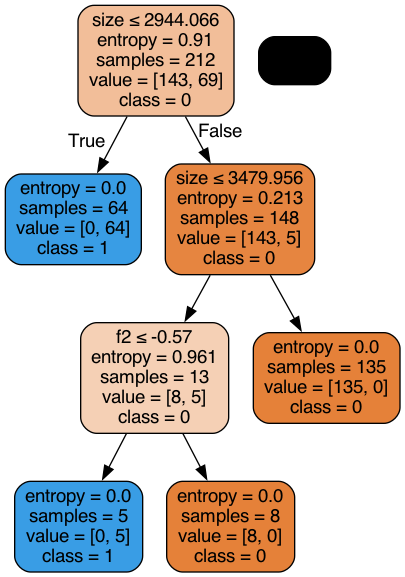

In [47]:
graph = renderTree(clf)
Image(graph.create_png())